In [1]:
input_sdate = "2023 08 20"
input_edate = "2023 08 25"
geometry=[-17.556111,-34.854167  , 51.464444 , 37.35   ]


In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import fsspec
import numpy as np
import xarray as xr
import planetary_computer
import pystac_client
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, time


In [3]:
# Initialize PySTAC client for data query
planetary_computer.set_subscription_key("c27669c4bdec434d804e2bd738cb16fc")
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Function to convert date format 
def convert_format_date(input_date):
    date_obj = datetime.strptime(input_date, "%Y %m %d")
    formatted_date = date_obj.strftime("%Y-%m-%d")
    return formatted_date

# Convert user start date format
input_sdate = convert_format_date(input_sdate)

# Convert user end date format
input_edate = convert_format_date(input_edate)

date_period = input_sdate + "/" + input_edate 
date_period

'2023-08-20/2023-08-25'

In [6]:
search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    bbox = geometry,
    datetime=input_sdate + "/" + input_edate,
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)
items = search.item_collection()

print(len(items))

28


/tmp/ipykernel_1420/4048737162.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset


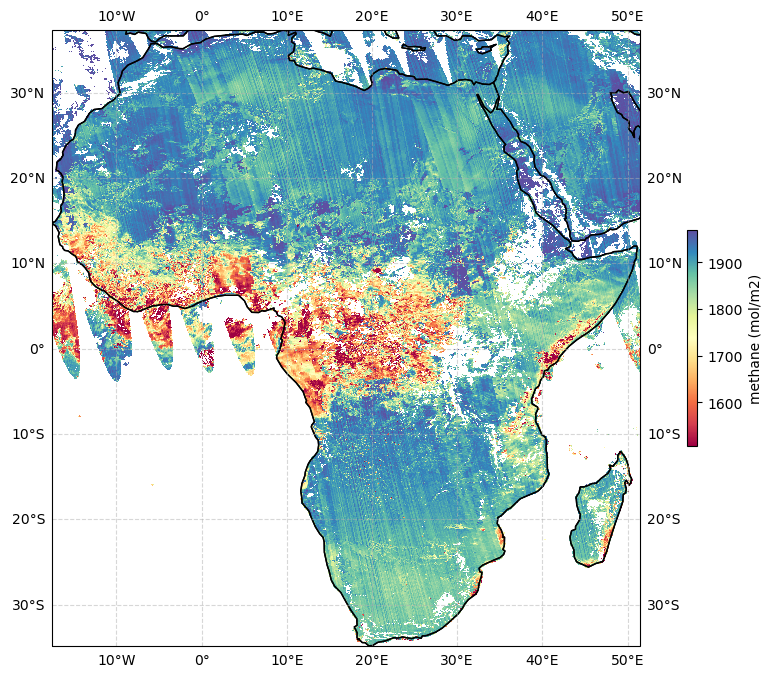

In [8]:
# Initialize the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
continent_borders = world.dissolve(by='continent')
continent_borders.boundary.plot(ax=ax, linewidth=1, color='black')
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
#ax.set_extent(geometry, crs=ccrs.PlateCarree())

# Loop through each item
for item in items:
    # Open the file
    with fsspec.open(item.assets['ch4'].href).open() as f:
        ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
        
        # Extract the relevant data (assuming the variable name is 'methane_mixing_ratio_bias_corrected')
        data = ds['methane_mixing_ratio_bias_corrected'][0, :, :]
        #print(data.values)
        lon = ds['longitude'].values.squeeze()
        lat = ds['latitude'].values.squeeze()
        
        # Calculate vmin and vmax for color normalization
        vmin, vmax = np.nanpercentile(data, [1, 99])
        
        # Plot the data
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        colormesh = ax.pcolormesh(lon, lat, data.values, cmap="Spectral", norm=norm, transform=ccrs.PlateCarree())


fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="methane (mol/m2)")
ax.set_xlim(geometry[0], geometry[2])
ax.set_ylim(geometry[1], geometry[3])

plt.show()
